In [1]:
import pandas as pd
import string
import unicodedata
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list
    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''
    
    #thresholds = np.sort(probabilities)
    thresholds = np.linspace(0.0, 1.0, num=100)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()

def plot_roc(model, X_test, y_test, ax):
    probabilities = model.predict_proba(X_test)[:, 1]

    tpr, fpr, thresholds = roc_curve(probabilities, y_test)

#     fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate (1 - Specificity)")
    ax.set_ylabel("True Positive Rate (Sensitivity, Recall)")
    ax.set_title("ROC plot of fake data")

In [3]:
data = pd.read_csv('text_polarity.csv', encoding = "ISO-8859-1", header=None)

In [7]:
data.shape

(800000, 6)

In [6]:
data.drop(data.index[400000:1200000], inplace = True)

In [8]:
smileyfaces = [':-)', ':)', ':D', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)']
sadfaces = ['>:[', ':-(', ':(', ':-c', ':c', ':-<', ':<', ':-[', ':[', ':{', '=(','=[', 'D:']
angryfaces = ['>:(']
cryingfaces = [":’-(", ":’("]
skepticalfaces = ['>:', '>:/', ':-/', '=/',':L', '=L', ':S', '>.<']
noexpressionfaces = [':|', ':-|']
surprisedfaces = ['>:O', ':-O', ':O', ':-o', ':o', '8O', 'O_O', 'o-o', 'O_o', 'o_O', 'o_o', 'O-O']

In [9]:
def cleanText(wordSeries):
    tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                          if unicodedata.category(chr(i)).startswith('P'))
    def remove_punctuation(text):
        return text.translate(tbl)
    for smile in smileyfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(smile, ' smileyface '))
    for sad in sadfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(sad,' sadface '))
    for angry in angryfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(angry, ' angryface '))
    for cry in cryingfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(cry, ' cryingface '))
    for skeptical in skepticalfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(skeptical, ' skepticalface '))
    for noexp in noexpressionfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(noexp, ' noexpressionfaces '))
    for surprised in surprisedfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(surprised, ' surprisedface '))
    wordSeries = wordSeries.apply(lambda x: x.replace('...', ' dotdotdot '))
    wordSeries = wordSeries.apply(lambda x: x.replace('!', ' exclamatory '))
    wordSeries = wordSeries.apply(lambda x: remove_punctuation(x))
    wordSeries = wordSeries.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
    wordSeries = wordSeries.apply(lambda x: x.lower())
    wordSeries = wordSeries.apply(lambda x: x.replace('<br >',' '))
    wordSeries = wordSeries.apply(lambda x: x.replace('<br>',' '))
    wordSeries = wordSeries.apply(lambda x: x.replace('`',''))
    wordSeries = wordSeries.apply(lambda x: x.replace(' id ', ' '))
    wordSeries = wordSeries.apply(lambda x: x.replace(' im ', ' '))
    #wordSeries = wordSeries.apply(lambda x: x.replace('http', ' '))
    wordSeries = wordSeries.apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] ))
    return wordSeries

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
def tokenize(documents):
    documents = cleanText(documents)
    docs = [word_tokenize(content) for content in documents]
    stopwords_=set(stopwords.words('english'))
    def filter_tokens(sent):
        return([w for w in sent if not w in stopwords_])
    docs=list(map(filter_tokens,docs))
    lemmatizer = WordNetLemmatizer()
    docs_lemma = [[lemmatizer.lemmatize(word) for word in words] for words in docs]
    return docs_lemma

In [11]:
data['Tokens'] = tokenize(data[5])

In [18]:
import operator
def createDict(token):
    words = {}
    for row in token:
        for word in row:
            if word in words:
                words[word] += 1
            else:
                words[word] = 1
    sorted_d = dict( sorted(words.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

In [19]:
positive = data[data[0] == 4]
negative = data[data[0] == 0]
positivewords = createDict(positive['Tokens'])
negativewords = createDict(negative['Tokens'])
words = createDict(data['Tokens'])

In [20]:
keys = [k for k in words]
vals = [v for v in words.values()]
keys_p = [k for k in positivewords]
vals_p = [v for v in positivewords.values()]
keys_n = [k for k in negativewords]
vals_n = [v for v in negativewords.values()]

In [21]:
import matplotlib.pyplot as plt

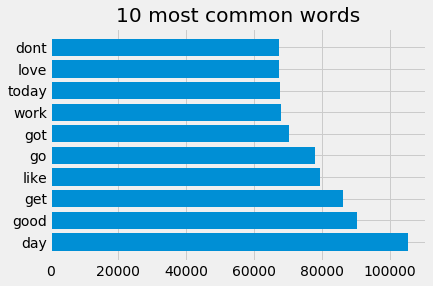

In [22]:
plt.barh(keys[2:12], vals[2:12], align='center')
plt.title("10 most common words")
plt.show()

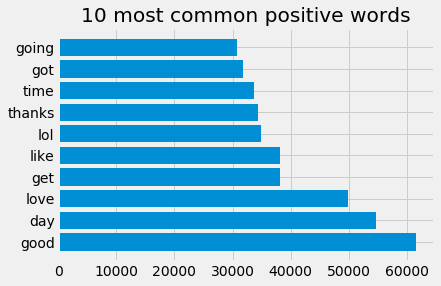

In [23]:
plt.barh(keys_p[2:12], vals_p[2:12], align='center')
plt.title("10 most common positive words")
plt.show()

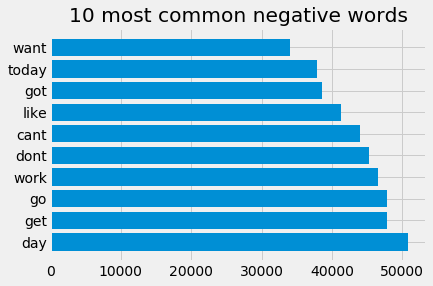

In [24]:
plt.barh(keys_n[2:12], vals_n[2:12], align='center')
plt.title("10 most common negative words")
plt.show()

In [12]:
data['tokenJ'] = data['Tokens'].apply(lambda x: ' '.join(x))
corpus = [row for row in data['tokenJ']]

In [13]:
tf = CountVectorizer()

document_tf_matrix = tf.fit_transform(corpus).todense()

tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(corpus)

In [14]:
data[0] = data[0].apply(lambda x: 1 if x == 4 else 0)

In [15]:
X = document_tfidf_matrix
y = data[0]

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.75)

In [18]:
lg = LogisticRegression(max_iter = 300)
lg.fit(Xtrain,ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
lg.score(Xtest, ytest)

0.7779233333333333

In [20]:
clf = DecisionTreeClassifier()
clf.fit(Xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [21]:
clf.score(Xtest, ytest)

0.702915

In [22]:
ridge = RidgeClassifier()
ridge.fit(Xtrain, ytrain)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [23]:
ridge.score(Xtest, ytest)

0.77004

In [44]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(Xtest, ytest)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

KeyboardInterrupt: 

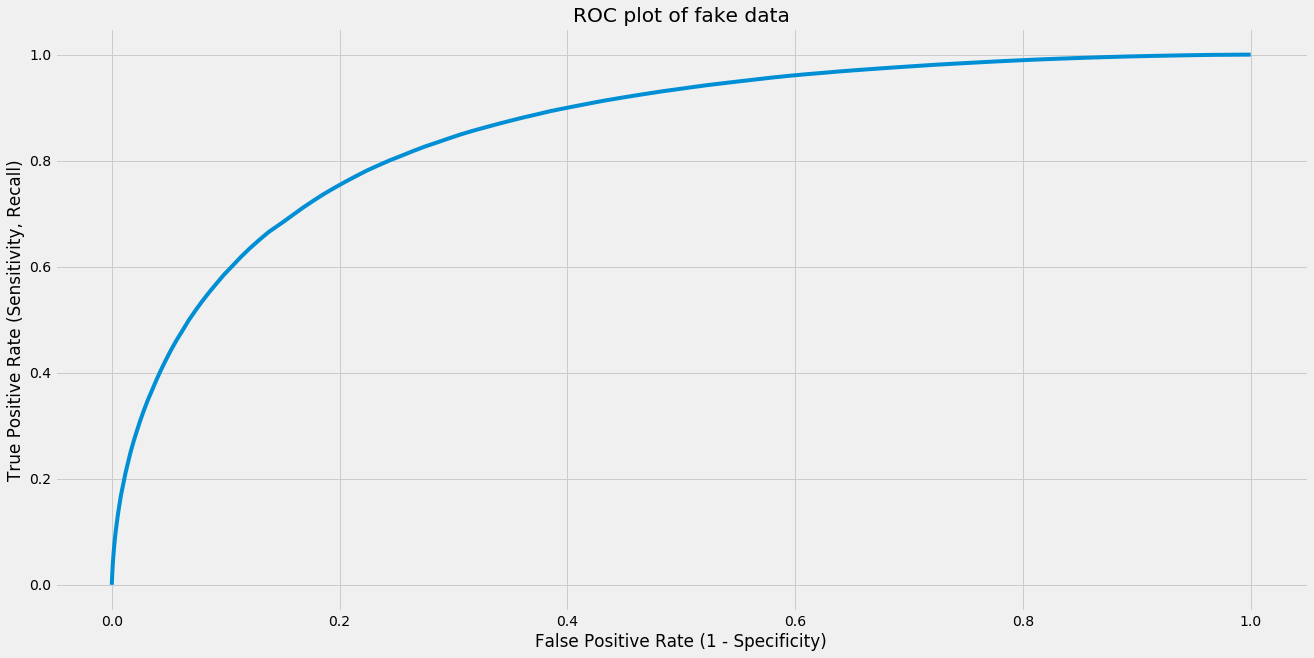

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
plot_roc(lg, Xtest, ytest, ax)
plot_roc(neigh, Xtest, ytest, ax)
ax.plot([0,1], [0,1])